In [1]:
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_coeffs
from sklearn.model_selection import train_test_split


In [ ]:
WINDOW = 10 
SLIDING_WINDOW = 5 
EPSILON_TOLERANCE = 0.20 

Lectura de archivos

In [3]:
tweets_df = pd.read_csv("../data/pre_cleaning/tweets_with_sentiment_cryptobert.csv")
price_df = pd.read_csv("../data/pre_cleaning/data_binance.csv")
tweets_df['fecha'] = pd.to_datetime(tweets_df['Created At'], errors='coerce')
# Asigna dia, mes y año a la nueva columna fecha quitando la hora
tweets_df['fecha'] = tweets_df['fecha'].dt.date
price_df['fecha'] = pd.to_datetime(price_df['fecha'], errors='coerce')
# Ordenar los dataframes por fecha
price_df.sort_values('fecha', inplace=True)
tweets_df.sort_values('fecha', inplace=True)

In [4]:
# We count by kind of feeling
count_sentiment = tweets_df.groupby(['fecha', 'Sentiment']).size().unstack(fill_value=0)

# We recalculate totals and average
count_sentiment['numero_noticias'] = count_sentiment.sum(axis=1)
count_sentiment['promedio_sentimiento'] = tweets_df.groupby('fecha')['Sentiment'].mean()

Transforma las columnas date en formato datetime.date

In [5]:
price_df['fecha'] = pd.to_datetime(price_df['fecha']).dt.date 
count_sentiment = count_sentiment.reset_index()  # si 'fecha' está en el índice
count_sentiment['fecha'] = pd.to_datetime(count_sentiment['fecha']).dt.date
count_sentiment.rename(
    columns={
        -1:'negative_sentiment_news',
        0:'neutral_sentiment_news',
        1:'positive_sentiment_news'
    },
    inplace=True
)


Realiza la fusión de los dos DataFrames (price_df y conteo_sentimientos) usando la columna fecha como clave



In [6]:
# We join by date
df_final = price_df.merge(count_sentiment, on='fecha', how='left')

CALCULO DE NUEVAS FEATURES DE SENTIMIENTO

1. Rolling Standard Deviation

    Un valor alto en sentiment_std_10d significa que en los últimos 10 días, el sentimiento ha sido muy volátil y ha fluctuado mucho (por ejemplo, pasando de muy positivo a muy negativo). Esto indica controversia o incertidumbre.

    Un valor bajo significa que el sentimiento ha sido muy estable y consistente durante los últimos 10 días.
2. Sentiment Momentum
    Un valor positivo significa que el sentimiento promedio de hoy es más positivo que el de ayer.
    Un valor negativo significa que el sentimiento se ha vuelto más negativo en comparación con ayer.
    Un valor cercano a cero indica que el sentimiento apenas ha cambiado.


In [ ]:
# 1. Rolling Standard Deviation (Volatilidad del Sentimiento) 
# std = calcula desviacion estandar
df_final['sentiment_std'] = df_final['promedio_sentimiento'].rolling(WINDOW).std()

# Rolling Mean (Promedio móvil del Sentimiento)
df_final['sentiment_mean'] = df_final['promedio_sentimiento'].rolling(WINDOW).mean()

# Rolling Skewness (Asimetría del Sentimiento)
df_final['sentiment_skew'] = df_final['promedio_sentimiento'].rolling(WINDOW).skew()

# Rolling Kurtosis (Curtosis del Sentimiento)
df_final['sentiment_kurtosis'] = df_final['promedio_sentimiento'].rolling(WINDOW).kurt()

# 2. Sentiment Momentum (Cambio diario en el sentimiento)
# .diff(): Esta función calcula la diferencia entre el valor de un día y el valor del día anterior.
df_final['sentiment_momentum'] = df_final['promedio_sentimiento'].diff()

CALCULO MEDIA MOVIL CON DERIVADA Y TENDENCIA

In [8]:
df_final['media_movil'] = df_final['precio_apertura'].rolling(WINDOW, min_periods=WINDOW).mean()
df_final['mm_smooth']  = df_final['media_movil']
df_final['derivada_mm'] = df_final['media_movil'].diff()



In [9]:
epsilon = df_final['derivada_mm'].std() * EPSILON_TOLERANCE
condition_list = [
    df_final['derivada_mm'].isna() | df_final['derivada_mm'].between(-epsilon, epsilon),
    df_final['derivada_mm'] > 0,
    df_final['derivada_mm'] < 0,
]
returns_values_list = [0, 1, -1]
df_final['tendencia_categorizada'] = np.select(condition_list, returns_values_list, 0)

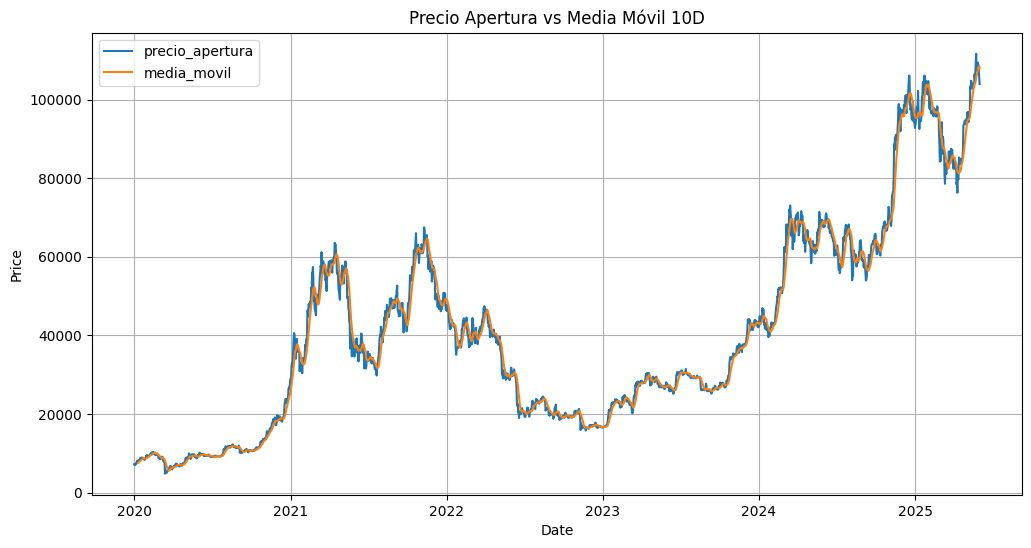

In [10]:
# Grafico precio apertura vs media movil 10d
df_temp = df_final.copy()
df_temp.set_index('fecha', inplace=True)
df_temp[['precio_apertura', 'media_movil']].plot(figsize=(12,6), title='Precio Apertura vs Media Móvil 10D', grid=True)
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()


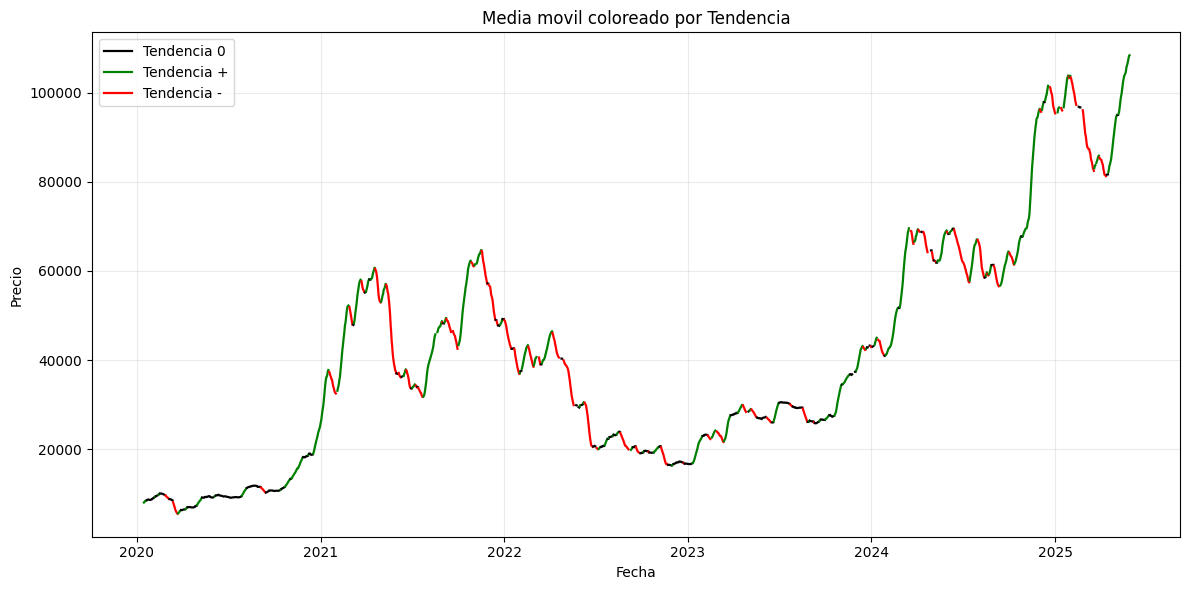

In [11]:
import itertools

# Data para graficar
df_plot = df_final[['fecha','media_movil','tendencia_categorizada']].dropna().copy()
df_plot = df_plot.sort_values('fecha').set_index('fecha')

fig, ax = plt.subplots(figsize=(12,6))
colors = {1:'green', 0:'black', -1:'red'}

first_label_done = set()

# Agrupar tramos consecutivos con misma tendencia
for trend, group in itertools.groupby(zip(df_plot.index, df_plot['tendencia_categorizada']), key=lambda x: x[1]):
    group_list = list(group)
    idxs = [ts for ts,_ in group_list]
    prices = df_plot.loc[idxs, 'media_movil']
    label = None
    if trend not in first_label_done:
        label = {1:'Tendencia +',0:'Tendencia 0',-1:'Tendencia -'}[trend]
        first_label_done.add(trend)
    ax.plot(prices.index, prices.values, color=colors[trend], linewidth=1.6, label=label)

ax.set_title('Media movil coloreado por Tendencia')
ax.set_ylabel('Precio')
ax.set_xlabel('Fecha')
ax.legend(loc='upper left')
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()
#

📈 Indicador RSI (Relative Strength Index)

📊 RSI toma valores entre 0 y 100:

- (<30) podría indicar sobreventa.
- (>70) podría indicar sobrecompra.

In [12]:
# PROFE TIPS: trata de no usar funciones creadas por ti para los indicadores
# LISTO CORREGIDO

df_final['RSI'] = talib.RSI(df_final['precio_apertura'], WINDOW)

🔁 Indicador MACD (Moving Average Convergence Divergence)


In [13]:
# EMA rápida y lenta
ema_12 = df_final['precio_apertura'].ewm(span=12, adjust=False).mean()
ema_26 = df_final['precio_apertura'].ewm(span=26, adjust=False).mean()

# Línea MACD y señal
df_final['MACD'] = ema_12 - ema_26
df_final['MACD_signal'] = df_final['MACD'].ewm(span=9, adjust=False).mean()

In [14]:
df_final.columns

Index(['simbolo', 'fecha', 'precio_apertura', 'precio_maximo', 'precio_minimo',
       'precio_cierre', 'volumen', 'negative_sentiment_news',
       'neutral_sentiment_news', 'positive_sentiment_news', 'numero_noticias',
       'promedio_sentimiento', 'sentiment_std', 'sentiment_mean',
       'sentiment_skew', 'sentiment_kurtosis', 'sentiment_momentum',
       'media_movil', 'mm_smooth', 'derivada_mm', 'tendencia_categorizada',
       'RSI', 'MACD', 'MACD_signal'],
      dtype='object')

Creación df con indicadores finales

In [15]:
# Selecting final columns
df_csv = df_final[['fecha',
                    'precio_apertura',
                    'media_movil', 
                    'RSI', 
                    'MACD_signal', 
                    'tendencia_categorizada', 
                    'numero_noticias',  
                    'promedio_sentimiento',
                    'sentiment_mean',
                    'sentiment_std',
                    'sentiment_momentum',
                    'sentiment_skew',
                    'sentiment_kurtosis',
                    'negative_sentiment_news',
                    'positive_sentiment_news',
                    'neutral_sentiment_news'
                    ]]

# We rename columns
df_csv.columns = ['date', 
                  'open',
                  'MA',
                  'RSI',
                  'MACD', 
                  'trend', 
                  'issue_news', 
                  'average_news',
                  'sentiment_mean',
                  'sentiment_std',
                  'sentiment_momentum',
                  'sentiment_skew',
                  'sentiment_kurtosis',
                  'negative_sentiment_news',
                  'positive_sentiment_news',
                  'neutral_sentiment_news'
                ]

In [16]:
df_final

,simbolo,fecha,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,negative_sentiment_news,neutral_sentiment_news,positive_sentiment_news,...,sentiment_skew,sentiment_kurtosis,sentiment_momentum,media_movil,mm_smooth,derivada_mm,tendencia_categorizada,RSI,MACD,MACD_signal
0,BTCUSDT,2020-01-01,7195.24,7255.00,7175.15,7200.85,16792.388165,1,16,7,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000,0.000000
1,BTCUSDT,2020-01-02,7200.77,7212.50,6924.74,6965.71,31951.483932,2,1,9,...,NaN,NaN,0.333333,NaN,NaN,NaN,0,NaN,0.441140,0.088228
2,BTCUSDT,2020-01-03,6965.49,7405.00,6871.04,7344.96,68428.500451,0,6,3,...,NaN,NaN,-0.250000,NaN,NaN,NaN,0,NaN,-17.987040,-3.526826
3,BTCUSDT,2020-01-04,7345.00,7404.00,7272.21,7354.11,29987.974977,0,5,5,...,NaN,NaN,0.166667,NaN,NaN,NaN,0,NaN,-1.945791,-3.210619
4,BTCUSDT,2020-01-05,7354.19,7495.00,7318.00,7358.75,38331.085604,2,5,1,...,NaN,NaN,-0.625000,NaN,NaN,NaN,0,NaN,11.377420,-0.293011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,BTCUSDT,2025-05-27,109434.78,110718.00,107516.57,108938.17,21276.656350,1,10,8,...,-0.729816,-0.740469,0.141148,107686.404,107686.404,597.088,1,66.138775,3769.126180,3868.602046
1974,BTCUSDT,2025-05-28,108938.17,109284.70,106769.43,107781.78,15633.788290,2,24,13,...,-0.675033,-0.914311,-0.086370,108267.556,108267.556,581.152,1,63.750214,3639.414671,3822.764571
1975,BTCUSDT,2025-05-29,107781.78,108891.91,105322.86,105589.75,19834.701160,7,25,13,...,-0.585302,-1.178983,-0.148718,108400.307,108400.307,132.751,1,58.302505,3404.066398,3739.024936
1976,BTCUSDT,2025-05-30,105589.75,106313.12,103621.00,103985.48,23706.497990,0,16,6,...,-0.339189,-1.139945,0.139394,108401.909,108401.909,1.602,0,49.409607,3006.021155,3592.424180


In [17]:
df_csv.head(20)

,date,open,MA,RSI,MACD,trend,issue_news,average_news,sentiment_mean,sentiment_std,sentiment_momentum,sentiment_skew,sentiment_kurtosis,negative_sentiment_news,positive_sentiment_news,neutral_sentiment_news
0,2020-01-01,7195.24,NaN,NaN,0.000000,0,24,0.250000,NaN,NaN,NaN,NaN,NaN,1,7,16
1,2020-01-02,7200.77,NaN,NaN,0.088228,0,12,0.583333,NaN,NaN,0.333333,NaN,NaN,2,9,1
2,2020-01-03,6965.49,NaN,NaN,-3.526826,0,9,0.333333,NaN,NaN,-0.250000,NaN,NaN,0,3,6
3,2020-01-04,7345.00,NaN,NaN,-3.210619,0,10,0.500000,NaN,NaN,0.166667,NaN,NaN,0,5,5
4,2020-01-05,7354.19,NaN,NaN,-0.293011,0,8,-0.125000,NaN,NaN,-0.625000,NaN,NaN,2,1,5
5,2020-01-06,7357.64,NaN,NaN,4.157869,0,8,0.375000,NaN,NaN,0.500000,NaN,NaN,0,3,5
6,2020-01-07,7758.90,NaN,NaN,15.728844,0,10,0.400000,NaN,NaN,0.025000,NaN,NaN,0,4,6
7,2020-01-08,8145.92,NaN,NaN,37.294816,0,13,0.384615,NaN,NaN,-0.015385,NaN,NaN,0,5,8
8,2020-01-09,8054.72,NaN,NaN,62.454890,0,6,0.333333,NaN,NaN,-0.051282,NaN,NaN,0,2,4
9,2020-01-10,7817.74,7519.561,NaN,84.625519,0,10,0.400000,0.343462,0.188421,0.066667,-1.775726,4.694986,1,5,4


ELIMINAR PRIMERAS 10 FILAS DONDE HAY VALORES NaN POR DATOS INCOMPLETOS PARA LA VENTANA MOVIL DE 10 DIAS

In [18]:
df_csv = df_csv.iloc[WINDOW:].reset_index(drop=True)

COMPROBACION VALORES NaN

In [19]:
# Cuantos valores NaN hay
df_csv.isna().sum().sum()

0

In [20]:
# Cuales filas tienen NaN
df_csv[df_csv.isna().any(axis=1)].head(30)

,date,open,MA,RSI,MACD,trend,issue_news,average_news,sentiment_mean,sentiment_std,sentiment_momentum,sentiment_skew,sentiment_kurtosis,negative_sentiment_news,positive_sentiment_news,neutral_sentiment_news


EXPORTAR FINAL DATA SIN VENTANA DESLIZANTE

In [21]:
df_csv.to_csv("../data/post_cleaning/data_without_sliding_window/final_data_without_sliding.csv", index=False)

In [22]:
training_set_w_sliding, temp_set = train_test_split(df_csv, test_size=0.30, shuffle=False)  
# 30% para test y validation

In [23]:
validation_set_w_sliding, test_set_w_sliding = train_test_split(temp_set, test_size=0.50, shuffle=False)  
#15% para test y 15% para validation

In [24]:
training_set_w_sliding.to_csv('../data/post_cleaning/data_without_sliding_window/training_set_w_sliding.csv', index=False)
validation_set_w_sliding.to_csv('../data/post_cleaning/data_without_sliding_window/validation_set_w_sliding.csv', index=False)
test_set_w_sliding.to_csv('../data/post_cleaning/data_without_sliding_window/test_set_w_sliding.csv', index=False)

Creación ventana deslizante

In [25]:
# Features
colums_windows = ['open',
                  'MA',
                  'RSI',
                  'MACD',
                  'trend',
                  'issue_news',
                  'average_news',
                  'sentiment_mean',
                  'sentiment_std',
                  'sentiment_momentum',
                  'sentiment_skew',
                  'sentiment_kurtosis',
                  'negative_sentiment_news',
                  'positive_sentiment_news',
                  'neutral_sentiment_news'
                  ]

# Lista para almacenar las wind
wind = []

# Recorremos desde el día 1 hasta len (cantidad de filas del df) - ventana 
for i in range(len(df_csv) - SLIDING_WINDOW):
    # Extraemos las filas de la ventana anterior (días pasados)
    segment = df_csv[colums_windows].iloc[i:i+SLIDING_WINDOW]
    
    # Aplanamos los datos de la ventana en una sola fila
    row_wind = segment.values.flatten()

    date = df_csv['date'].iloc[i-1 + SLIDING_WINDOW]
    #Precio objetivo: el siguiente día después de la ventana
    target_trend = df_csv['trend'].iloc[i + SLIDING_WINDOW]

    # Se crea la fila con target_date, target_trend y la ventana
    wind.append([date] + row_wind.tolist() + [target_trend])
    
columns_name = ['date']
# Generacion de columnas "open_d1, RS1_d1, open_d2, etc" de la ventana deslizante


x = (np.arange(SLIDING_WINDOW) * -1)[::-1]
for i, day in enumerate(x) :
    for col in colums_windows:
        columns_name.append(f'{col}_d{day}')
# Se crea la columna de target
columns_name.append('target_trend')



In [26]:
# DataFrame final
df_sliding_window = pd.DataFrame(wind, columns=columns_name)

In [27]:
df_sliding_window.head(5)

,date,open_d-4,MA_d-4,RSI_d-4,MACD_d-4,trend_d-4,issue_news_d-4,average_news_d-4,sentiment_mean_d-4,sentiment_std_d-4,...,average_news_d0,sentiment_mean_d0,sentiment_std_d0,sentiment_momentum_d0,sentiment_skew_d0,sentiment_kurtosis_d0,negative_sentiment_news_d0,positive_sentiment_news_d0,neutral_sentiment_news_d0,target_trend
0,2020-01-15,8198.86,7619.923,73.553184,109.647870,1.0,9.0,0.444444,0.362906,0.187736,...,0.100000,0.303858,0.129547,-0.233333,-0.822387,-1.198112,1.0,2.0,7.0,1
1,2020-01-16,8020.01,7701.847,67.277955,132.042554,0.0,8.0,0.125000,0.317073,0.183850,...,0.090909,0.275449,0.142695,-0.009091,-0.336630,-2.028254,1.0,2.0,8.0,1
2,2020-01-17,8184.97,7823.795,69.908909,153.947191,1.0,7.0,0.142857,0.298025,0.191678,...,0.555556,0.291005,0.164581,0.464646,0.049487,-1.408635,0.0,5.0,4.0,0
3,2020-01-18,8110.34,7900.329,67.193157,172.854843,0.0,6.0,0.333333,0.281358,0.178991,...,0.153846,0.267928,0.166168,-0.401709,0.469652,-1.257812,1.0,3.0,9.0,1
4,2020-01-19,8814.64,8046.374,76.688793,199.735597,1.0,10.0,0.100000,0.303858,0.129547,...,0.555556,0.290150,0.189156,0.401709,0.358154,-1.768012,0.0,5.0,4.0,1


EXPORTAR A FINAL_DATA.CSV

In [28]:
# Exportar a CSV
df_sliding_window.to_csv('../data/post_cleaning/final_data.csv', index=False)

In [29]:
df_sliding_window

,date,open_d-4,MA_d-4,RSI_d-4,MACD_d-4,trend_d-4,issue_news_d-4,average_news_d-4,sentiment_mean_d-4,sentiment_std_d-4,...,average_news_d0,sentiment_mean_d0,sentiment_std_d0,sentiment_momentum_d0,sentiment_skew_d0,sentiment_kurtosis_d0,negative_sentiment_news_d0,positive_sentiment_news_d0,neutral_sentiment_news_d0,target_trend
0,2020-01-15,8198.86,7619.923,73.553184,109.647870,1.0,9.0,0.444444,0.362906,0.187736,...,0.100000,0.303858,0.129547,-0.233333,-0.822387,-1.198112,1.0,2.0,7.0,1
1,2020-01-16,8020.01,7701.847,67.277955,132.042554,0.0,8.0,0.125000,0.317073,0.183850,...,0.090909,0.275449,0.142695,-0.009091,-0.336630,-2.028254,1.0,2.0,8.0,1
2,2020-01-17,8184.97,7823.795,69.908909,153.947191,1.0,7.0,0.142857,0.298025,0.191678,...,0.555556,0.291005,0.164581,0.464646,0.049487,-1.408635,0.0,5.0,4.0,0
3,2020-01-18,8110.34,7900.329,67.193157,172.854843,0.0,6.0,0.333333,0.281358,0.178991,...,0.153846,0.267928,0.166168,-0.401709,0.469652,-1.257812,1.0,3.0,9.0,1
4,2020-01-19,8814.64,8046.374,76.688793,199.735597,1.0,10.0,0.100000,0.303858,0.129547,...,0.555556,0.290150,0.189156,0.401709,0.358154,-1.768012,0.0,5.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,2025-05-26,109643.99,104927.912,78.320961,3792.846638,1.0,45.0,0.422222,0.329133,0.128724,...,0.227273,0.337955,0.129827,-0.201299,-0.744097,-0.737487,1.0,6.0,15.0,1
1959,2025-05-27,111696.22,105818.402,81.352864,3879.922064,1.0,31.0,0.161290,0.322185,0.136276,...,0.368421,0.337297,0.129635,0.141148,-0.729816,-0.740469,1.0,8.0,10.0,1
1960,2025-05-28,107318.30,106139.860,61.098972,3913.332858,1.0,10.0,0.400000,0.347370,0.123182,...,0.282051,0.315502,0.116941,-0.086370,-0.675033,-0.914311,2.0,13.0,24.0,1
1961,2025-05-29,107761.90,106565.267,62.159623,3909.514352,1.0,14.0,0.428571,0.356894,0.125633,...,0.133333,0.317724,0.112762,-0.148718,-0.585302,-1.178983,7.0,13.0,25.0,0


EXPORTAR training_set, validation_set y test_set


In [30]:
training_set, temp_set = train_test_split(df_sliding_window, test_size=0.30, shuffle=False)  
# 30% para test y validation

In [31]:
validation_set, test_set = train_test_split(temp_set, test_size=0.50, shuffle=False)  
#15% para test y 15% para validation

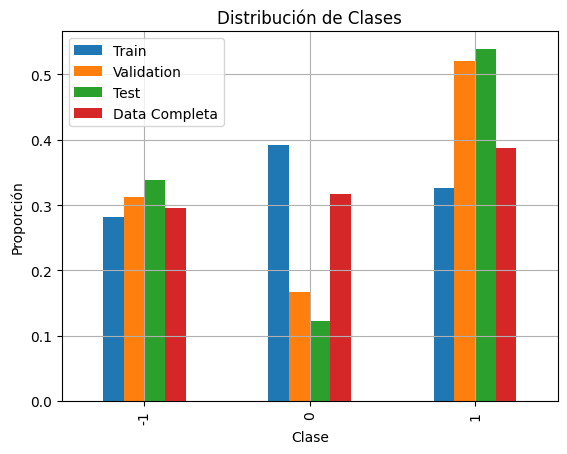

In [32]:
# Convertimos a DataFrame para facilitar la visualización

final_distribution = df_sliding_window['target_trend'].value_counts(normalize=True)
train_distribution = pd.Series(training_set['target_trend']).value_counts(normalize=True)
validation_distribution = pd.Series(validation_set['target_trend']).value_counts(normalize=True)
test_distribution = pd.Series(test_set['target_trend']).value_counts(normalize=True)

# Comparar visualmente
df = pd.DataFrame({
    'Train': train_distribution,
    'Validation': validation_distribution,
    'Test': test_distribution,

    'Data Completa': final_distribution
    
}).fillna(0)

df.plot(kind='bar', title='Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Proporción')
plt.grid(True)
plt.show()

In [33]:
training_set.to_csv('../data/post_cleaning/training_set.csv', index=False)
validation_set.to_csv('../data/post_cleaning/validation_set.csv', index=False)
test_set.to_csv('../data/post_cleaning/test_set.csv', index=False)